1. Разложение данных в разные таблички df
2. Обучение разных моделек на своих цветах
3. Соединение результатов

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install opencv-python

In [40]:
import numpy as np
import scipy.linalg as sla
from PIL import Image
from scipy import misc
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import timeit
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA

import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

from matplotlib import cm

from tqdm.auto import tqdm

## Сбор датасетов

In [4]:
name_folder = {0:'1_предупреждающие', 1:'2_приоритета', 2:'3_запрещающие', 3:'4_предписывающие', 4:'5_особых предписаний', 5:'6_информационные', 6:'7_сервиса', 7:'8_доп информации(таблички)'}

In [5]:
# df_0 = pd.DataFrame(columns=[i for i in range(50176)])
# df_1 = pd.DataFrame(columns=[i for i in range(50176)])
# df_2 = pd.DataFrame(columns=[i for i in range(50176)])


# for b in name_folder.keys():

#   path = '/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС'+f'/{name_folder[b]}'

#   photos = os.listdir(path)

#   img_sl = {}

#   for i, photo in enumerate(tqdm(photos)):

#     photo_pth = f'{path}/'+f'{photo}'     

#     img = 255 - cv2.imread(photo_pth, cv2.COLOR_BGR2RGB)

#     for n in range(3):

#       data0 = np.reshape(img[:,:,n], 50176)
#       data0 = pd.Series(data0)
#       img_sl[n] = data0

#     df_0 = df_0.append(img_sl[0], ignore_index=True)
#     df_0.loc[(df_0.shape[0] - 1), 'target'] = b

#     df_1 = df_1.append(img_sl[1], ignore_index=True)
#     df_1.loc[(df_0.shape[0] - 1), 'target'] = b

#     df_2 = df_2.append(img_sl[2], ignore_index=True)
#     df_2.loc[(df_2.shape[0] - 1), 'target'] = b

In [6]:
# df_0.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_0.csv')
# df_1.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_1.csv')
# df_2.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2.csv')


## Загрузим датасеты

In [7]:
df_0 = pd.read_csv('C:/Users/nicol/Python/ВШЭ/НИС/df_0.csv', index_col = 0)
df_1 = pd.read_csv('C:/Users/nicol/Python/ВШЭ/НИС/df_1.csv', index_col = 0)
df_2 = pd.read_csv('C:/Users/nicol/Python/ВШЭ/НИС/df_2.csv', index_col = 0)

In [8]:
df_0.head()

,0,1,2,3,4,5,6,7,8,9,...,50167,50168,50169,50170,50171,50172,50173,50174,50175,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Опыты PCA

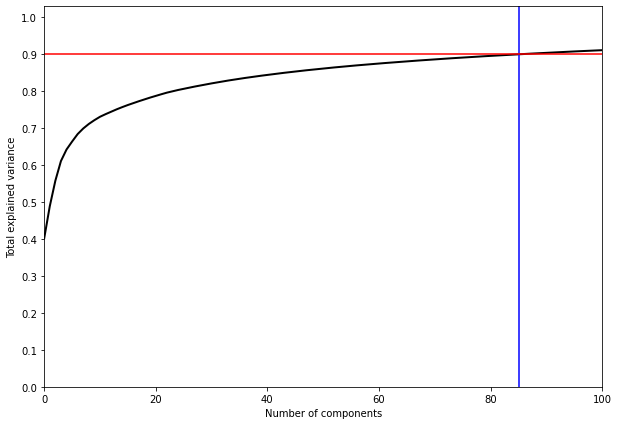

In [76]:
model_pca = PCA()
df_0_x = df_0.drop('target', axis=1)
faces_images = df_0_x
model_pca.fit(faces_images.values)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(85, c='b')
plt.axhline(0.9, c='r')
plt.show();

#### 85 признаков сохраняют 90% инфрмации

## Функция для обучения c PCA

In [77]:
def model_ka_pca(df_0, df_1, df_2, mod_0, mod_1, mod_2, n_pca):
   
    # разбиение индексов
    x_train_ind, x_test_ind = train_test_split(df_0.index, test_size=0.3, random_state=42)
    
    # разбивка данных для обучения моделек
    x_y_train_0 = df_0.loc[x_train_ind]
    x_y_train_1 = df_1.loc[x_train_ind]
    x_y_train_2 = df_2.loc[x_train_ind]

    x_y_test_0 = df_0.loc[x_test_ind]
    x_y_test_1 = df_1.loc[x_test_ind]
    x_y_test_2 = df_2.loc[x_test_ind]


    x_train_0 = x_y_train_0.drop('target', axis=1)
    x_train_1 = x_y_train_1.drop('target', axis=1)
    x_train_2 = x_y_train_2.drop('target', axis=1)

    x_test_0 = x_y_test_0.drop('target', axis=1)
    x_test_1 = x_y_test_1.drop('target', axis=1)
    x_test_2 = x_y_test_2.drop('target', axis=1)

    y_train = x_y_train_0['target']

    y_test = x_y_test_0['target']
    
    
    # применим PCA
    model_pca_0 = PCA(n_pca)
    model_pca_1 = PCA(n_pca)
    model_pca_2 = PCA(n_pca)
    
    x_train_0_pca = model_pca_0.fit_transform(x_train_0)
    x_train_1_pca = model_pca_1.fit_transform(x_train_1)
    x_train_2_pca = model_pca_2.fit_transform(x_train_2)
    
    x_test_0_pca = model_pca_0.transform(x_test_0)
    x_test_1_pca = model_pca_1.transform(x_test_1)
    x_test_2_pca = model_pca_2.transform(x_test_2)
    
    
    
    # обучение моделек, получение предсказаний для каждой
 
    mod_0.fit(x_train_0_pca, y_train)
    mod_1.fit(x_train_1_pca, y_train)
    mod_2.fit(x_train_2_pca, y_train)
    
    pred_0 = mod_0.predict(x_test_0_pca)
    pred_1 = mod_1.predict(x_test_1_pca)
    pred_2 = mod_2.predict(x_test_2_pca)
    
    
    # самое часто встречающееся значение среди всех предсказаний через медиану
    try:
        pred = list(map(np.median, (list(zip(pred_0[:,0],pred_1[:,0],pred_2[:,0])))))
    
    except IndexError:

        pred = list(map(np.median, (list(zip(pred_0,pred_1,pred_2)))))
    
    # считаем accuracy каждой модельки и суммарное
    
    accuracy_0 = accuracy_score(pred_0, y_test)
    accuracy_1 = accuracy_score(pred_1, y_test)
    accuracy_2 = accuracy_score(pred_2, y_test)
    
    accuracy_vseh = accuracy_score(pred, y_test)
    
    itog = {'1_канал': accuracy_0, '2_канал': accuracy_1, '3_канал':accuracy_2, 'суммарное':accuracy_vseh}
    
    return itog

## Функция для обучения 

In [9]:
def model_ka(df_0, df_1, df_2, mod_0, mod_1, mod_2):
   
    # разбиение индексов
    x_train_ind, x_test_ind = train_test_split(df_0.index, test_size=0.3, random_state=42)
    
    # разбивка данных для обучения моделек
    x_y_train_0 = df_0.loc[x_train_ind]
    x_y_train_1 = df_1.loc[x_train_ind]
    x_y_train_2 = df_2.loc[x_train_ind]

    x_y_test_0 = df_0.loc[x_test_ind]
    x_y_test_1 = df_1.loc[x_test_ind]
    x_y_test_2 = df_2.loc[x_test_ind]


    x_train_0 = x_y_train_0.drop('target', axis=1)
    x_train_1 = x_y_train_1.drop('target', axis=1)
    x_train_2 = x_y_train_2.drop('target', axis=1)

    x_test_0 = x_y_test_0.drop('target', axis=1)
    x_test_1 = x_y_test_1.drop('target', axis=1)
    x_test_2 = x_y_test_2.drop('target', axis=1)

    y_train = x_y_train_0['target']

    y_test = x_y_test_0['target']
    
    
    # обучение моделек, получение предсказаний для каждой
 
    mod_0.fit(x_train_0, y_train)
    mod_1.fit(x_train_1, y_train)
    mod_2.fit(x_train_2, y_train)
    
    pred_0 = mod_0.predict(x_test_0)
    pred_1 = mod_1.predict(x_test_1)
    pred_2 = mod_2.predict(x_test_2)
    
    
    # самое часто встречающееся значение среди всех предсказаний через медиану
    try:
        pred = list(map(np.median, (list(zip(pred_0[:,0],pred_1[:,0],pred_2[:,0])))))
    
    except IndexError:

        pred = list(map(np.median, (list(zip(pred_0,pred_1,pred_2)))))
    
    # считаем accuracy каждой модельки и суммарное
    
    accuracy_0 = accuracy_score(pred_0, y_test)
    accuracy_1 = accuracy_score(pred_1, y_test)
    accuracy_2 = accuracy_score(pred_2, y_test)
    
    accuracy_vseh = accuracy_score(pred, y_test)
    
    itog = {'1_канал': accuracy_0, '2_канал': accuracy_1, '3_канал':accuracy_2, 'суммарное':accuracy_vseh}
    
    return itog

## Обучим модели

In [138]:
n_pca = 100

### SGDClassifier

In [139]:
cl_0 = SGDClassifier()
cl_1 = SGDClassifier()
cl_2 = SGDClassifier()

In [140]:
model_ka(df_0, df_1, df_2, cl_0, cl_1, cl_2)

{'1_канал': 0.782608695652174,
 '2_канал': 0.7922705314009661,
 '3_канал': 0.7632850241545893,
 'суммарное': 0.7971014492753623}

In [141]:
cl_0 = SGDClassifier(penalty = 'l1')
cl_1 = SGDClassifier(penalty = 'l1')
cl_2 = SGDClassifier(penalty = 'l1')

In [142]:
m_sgd = model_ka(df_0, df_1, df_2, cl_0, cl_1, cl_2)
m_sgd

{'1_канал': 0.7681159420289855,
 '2_канал': 0.821256038647343,
 '3_канал': 0.782608695652174,
 'суммарное': 0.8454106280193237}

c PCA

In [143]:
m_sgd_pca = model_ka_pca(df_0, df_1, df_2, cl_0, cl_1, cl_2, n_pca)
m_sgd_pca

{'1_канал': 0.7101449275362319,
 '2_канал': 0.7246376811594203,
 '3_канал': 0.6859903381642513,
 'суммарное': 0.7681159420289855}

### SVC

In [144]:
svc_0 = SVC(kernel='rbf')
svc_1 = SVC(kernel='rbf')
svc_2 = SVC(kernel='rbf')

In [145]:
model_ka(df_0, df_1, df_2, svc_0, svc_1, svc_2)

{'1_канал': 0.6666666666666666,
 '2_канал': 0.7632850241545893,
 '3_канал': 0.748792270531401,
 'суммарное': 0.7584541062801933}

In [146]:
svc_0 = SVC(kernel='linear')
svc_1 = SVC(kernel='linear')
svc_2 = SVC(kernel='linear')

In [147]:
m_svc = model_ka(df_0, df_1, df_2, svc_0, svc_1, svc_2)
m_svc

{'1_канал': 0.7874396135265701,
 '2_канал': 0.8260869565217391,
 '3_канал': 0.7971014492753623,
 'суммарное': 0.8405797101449275}

с PCA

In [148]:
m_svc_pca = model_ka_pca(df_0, df_1, df_2, svc_0, svc_1, svc_2, n_pca)
m_svc_pca

{'1_канал': 0.714975845410628,
 '2_канал': 0.8067632850241546,
 '3_канал': 0.7681159420289855,
 'суммарное': 0.7922705314009661}

### KNeighborsClassifier

In [149]:
cn_0 = KNeighborsClassifier(n_jobs = -1)
cn_1 = KNeighborsClassifier(n_jobs = -1)
cn_2 = KNeighborsClassifier(n_jobs = -1)

In [150]:
model_ka(df_0, df_1, df_2, cn_0, cn_1, cn_2)

{'1_канал': 0.6183574879227053,
 '2_канал': 0.6956521739130435,
 '3_канал': 0.714975845410628,
 'суммарное': 0.6859903381642513}

In [151]:
cn_0 = KNeighborsClassifier(n_jobs = -1, weights='distance')
cn_1 = KNeighborsClassifier(n_jobs = -1, weights='distance')
cn_2 = KNeighborsClassifier(n_jobs = -1, weights='distance')

In [152]:
model_ka(df_0, df_1, df_2, cn_0, cn_1, cn_2)

{'1_канал': 0.6231884057971014,
 '2_канал': 0.7101449275362319,
 '3_канал': 0.748792270531401,
 'суммарное': 0.6956521739130435}

In [153]:
cn_0 = KNeighborsClassifier(n_jobs = -1, weights='distance', n_neighbors = 2)
cn_1 = KNeighborsClassifier(n_jobs = -1, weights='distance', n_neighbors = 2)
cn_2 = KNeighborsClassifier(n_jobs = -1, weights='distance', n_neighbors = 2)

In [154]:
m_kn = model_ka(df_0, df_1, df_2, cn_0, cn_1, cn_2)
m_kn

{'1_канал': 0.714975845410628,
 '2_канал': 0.7777777777777778,
 '3_канал': 0.8357487922705314,
 'суммарное': 0.8019323671497585}

c PCA

In [155]:
m_kn_pca = model_ka_pca(df_0, df_1, df_2, cn_0, cn_1, cn_2, n_pca)
m_kn_pca

{'1_канал': 0.7342995169082126,
 '2_канал': 0.8164251207729468,
 '3_канал': 0.855072463768116,
 'суммарное': 0.8309178743961353}

### RandomForestClassifier

In [156]:
rf_0 = RandomForestClassifier()
rf_1 = RandomForestClassifier()
rf_2 = RandomForestClassifier()

In [157]:
m_rf = model_ka(df_0, df_1, df_2, rf_0, rf_1, rf_2)
m_rf

{'1_канал': 0.7777777777777778,
 '2_канал': 0.7874396135265701,
 '3_канал': 0.7729468599033816,
 'суммарное': 0.8067632850241546}

c PCA

In [158]:
m_rf_pca = model_ka_pca(df_0, df_1, df_2, rf_0, rf_1, rf_2, n_pca)
m_rf_pca

{'1_канал': 0.7681159420289855,
 '2_канал': 0.7777777777777778,
 '3_канал': 0.8260869565217391,
 'суммарное': 0.8019323671497585}

### CatBoost

In [159]:
clf_0 = CatBoostClassifier(loss_function='MultiClass',depth = 3,\
                                                iterations = 180,\
                                                l2_leaf_reg = 1,\
                                                learning_rate = 0.25075,
                                                verbose=False)

In [160]:
clf_1 = CatBoostClassifier(loss_function='MultiClass',depth = 3,\
                                                iterations = 180,\
                                                l2_leaf_reg = 1,\
                                                learning_rate = 0.25075,
                                                verbose=False)

In [161]:
clf_2 = CatBoostClassifier(loss_function='MultiClass',depth = 3,\
                                                iterations = 180,\
                                                l2_leaf_reg = 1,\
                                                learning_rate = 0.25075,
                                                verbose=False)

In [162]:
# m_cb = model_ka(df_0, df_1, df_2, clf_0, clf_1, clf_2)
# m_cb

In [163]:
m_cb = {'1_канал': 0.7246376811594203,
 '2_канал': 0.7632850241545893,
 '3_канал': 0.7971014492753623,
 'суммарное': 0.7681159420289855}

c PCA

In [164]:
m_cb_pca = model_ka_pca(df_0, df_1, df_2, clf_0, clf_1, clf_2, n_pca)
m_cb_pca

{'1_канал': 0.7536231884057971,
 '2_канал': 0.7922705314009661,
 '3_канал': 0.7922705314009661,
 'суммарное': 0.8019323671497585}

## Графики и вывод

In [165]:
list(m_sgd.keys())

['1_канал', '2_канал', '3_канал', 'суммарное']

In [166]:
no_pca = {'SGDClassifier':m_sgd['суммарное'], 
          'SVC':m_svc['суммарное'],
          'KNeighbors':m_kn['суммарное'],
          'RandomForest':m_rf['суммарное'],
          'CatBoost':m_cb['суммарное']}


with_pca = {'SGDClassifier':m_sgd_pca['суммарное'], 
          'SVC':m_svc_pca['суммарное'],
          'KNeighbors':m_kn_pca['суммарное'],
          'RandomForest':m_rf_pca['суммарное'],
          'CatBoost':m_cb_pca['суммарное']}

In [167]:
fig = go.Figure(data=[
    go.Bar(name='SGDClassifier', x=list(m_sgd.keys()), y=list(m_sgd.values())),
    go.Bar(name='SVC', x=list(m_svc.keys()), y=list(m_svc.values())),
    go.Bar(name='KNeighbors', x=list(m_kn.keys()), y=list(m_kn.values())),
    go.Bar(name='RandomForest', x=list(m_rf.keys()), y=list(m_rf.values())),
    go.Bar(name='CatBoost', x=list(m_cb.keys()), y=list(m_cb.values())),
])


fig.update_yaxes(title_text="Accuracy", range = (0.6,0.85))
fig.update_xaxes(title_text="Канал (цвет)")
fig.update_layout(title = 'Accuracy моделек обученных на разных каналах + ансамбль')
fig.show()


fig2 = go.Figure(data=[
    go.Bar(name='NO_PCA', x=list(no_pca.keys()), y=list(no_pca.values())),
    go.Bar(name='WITH_PCA', x=list(with_pca.keys()), y=list(with_pca.values())),
])


fig2.update_yaxes(title_text="Accuracy", range = (0.6,0.85))
fig2.update_xaxes(title_text="PCA")
fig2.update_layout(title = 'Accuracy моделек c использованием и без PCA')
fig2.show()

- хуже всех модельки обучаются на 1 канале (красный цвет)
- лучше всех на голубом
- на SVC и RandomForest суммарная модель показывает лучшие результаты чем на отдельных каналах (проверить на стабильность)
- лучший результат у SVC (0.84)
- при снижении размерности в 500 раз качество у KNeighbors и CatBoost выросло
- обучение моделей с использованием PCA происходит быстрее, особенно в случае CatBoost